# データ作成

In [1]:
import numpy as np
import pandas as pd

データファイルの作成のためには，以下で説明するGDPと失業率のファイルをこのJupyter Notebookと同じフォルダーに置くことを前提とする。

## GDP

### 1994Q1-2020Q1

* 実額・四半期・実質季節調整系列（CSV形式：34KB）
    * ファイル名：gaku-jk2012.csv
    * [リンク](https://www.esri.cao.go.jp/jp/sna/data/data_list/sokuhou/files/2020/qe201_2/gdemenuja.html)
* ダウンロード後の作業
    * Exel：＜ファイル＞→＜名前を付けて保存＞
        * ＜ファイル形式＞を「CSV UTF-8(コンマ区切り)(.scv)」を選択し保存
    
読み込む列を指定する。

In [2]:
df1994_2020 = pd.read_csv('./gaku-jk2012.csv').iloc[6:-2,[0,1]]
df1994_2020.head()
# df1994_2020.tail()

,実質季節調整系列,Unnamed: 1
6,1994/ 1- 3.,"425,124.30"
7,4- 6.,"423,053.30"
8,7- 9.,"427,848.10"
9,10-12.,"426,084.10"
10,1995/ 1- 3.,"430,980.60"


列名変更

In [3]:
df1994_2020.columns = ['year','gdp']
df1994_2020.head(2)

,year,gdp
6,1994/ 1- 3.,"425,124.30"
7,4- 6.,"423,053.30"


* インデックの変更
* 列`year`を削除

In [4]:
idx = pd.Series(pd.date_range('1994', freq='Q', periods=105))    
df1994_2020 = df1994_2020.set_index(idx).drop('year',axis=1)
df1994_2020.columns

Index(['gdp'], dtype='object')

* 数字の`,`を削除
* `float`に変換

In [5]:
df1994_2020['gdp'] = df1994_2020['gdp'].str.replace(',','').astype(float)

図示

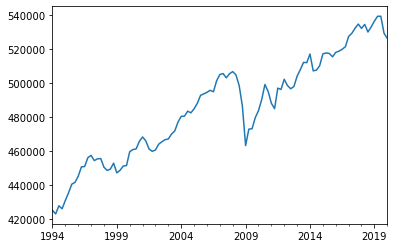

In [6]:
_ = df1994_2020['gdp'].plot()

### 1980Q1-1993Q1

* 実額・四半期・実質季節調整系列（CSV形式：34KB）
    * ファイル名：gaku-jk_1980.csv
    * [リンク](https://www.esri.cao.go.jp/jp/sna/data/data_list/h23_retroactive/23kani_top.html)
    * 平成23年基準支出側GDP系列簡易遡及
        * 正式ではないが上のデータと接続可能
* ダウンロード後の作業
    * Exel：＜ファイル＞→＜名前を付けて保存＞
        * ＜ファイル形式＞を「CSV UTF-8(コンマ区切り)(.scv)」を選択し保存    
    
読み込む行列を指定する。

In [7]:
df1980_1993 = pd.read_csv('./gaku-jk_1980.csv').iloc[6:-8,[0,1]]
df1980_1993.head()
df1980_1993.tail()

,実質季節調整系列,Unnamed: 1
57,10-12.,"422,433.80"
58,1993/ 1- 3.,"424,712.30"
59,4- 6.,"421,007.60"
60,7- 9.,"418,873.90"
61,10-12.,"420,500.10"


列名変更

In [8]:
df1980_1993.columns = ['year','gdp']
df1980_1993.head(2)

,year,gdp
6,1980/ 1- 3.,"257,829.70"
7,4- 6.,"255,945.60"


* インデックの変更
* 列`year`を削除

In [9]:
idx = pd.Series(pd.date_range('1980', freq='Q', periods=len(df1980_1993)))
df1980_1993 = df1980_1993.set_index(idx).drop('year',axis=1)
df1980_1993.columns

Index(['gdp'], dtype='object')

* 数字の`,`を削除
* `float`に変換

In [10]:
df1980_1993['gdp'] = df1980_1993['gdp'].str.replace(',','').astype(float)

図示

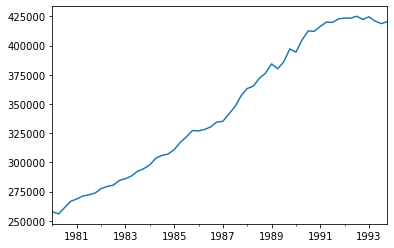

In [11]:
_ = df1980_1993['gdp'].plot()

### データの結合

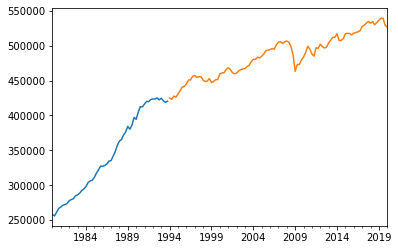

In [12]:
df1980_1993['gdp'].plot()
df1994_2020['gdp'].plot()
pass

In [13]:
df1980_2020 = pd.concat([df1980_1993, df1994_2020])

In [14]:
df1980_2020.index[54:58]

DatetimeIndex(['1993-09-30', '1993-12-31', '1994-03-31', '1994-06-30'], dtype='datetime64[ns]', freq=None)

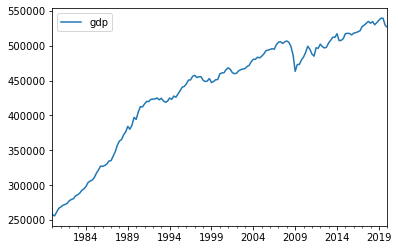

In [15]:
df1980_2020.plot()
pass

## 失業率

* 景気動向指数（速報、改訂値）（月次） 結果
    * 系列 （令和2(2020)年8月7日）個別系列の数値
    * 遅行系列(Excel形式：53KB)
    * 0807ci3.xlsx
    * [リンク](https://www.esri.cao.go.jp/jp/stat/di/di.html)
    
読み込む行列を指定する。

In [16]:
df_u = pd.read_excel('./0807ci3.xlsx').iloc[64:547,[1,2,8]]
df_u.head()
df_u.tail()

,Unnamed: 1,Unnamed: 2,Lg6
542,2019,11,2.21
543,2019,12,2.19
544,2020,1,2.38
545,2020,2,2.39
546,2020,3,2.49


列ラベルを変更

In [17]:
df_u.columns =['year','month','unemployment_rate']
df_u.head()

,year,month,unemployment_rate
64,1980,1,1.95
65,1980,2,1.87
66,1980,3,1.94
67,1980,4,1.98
68,1980,5,1.95


* インデックの変更
* 列`year`と`month`を削除

In [18]:
idx_u = pd.Series(pd.date_range('1980', freq='M', periods=len(df_u)))
df_u = df_u.set_index(idx_u).drop(['year','month'],axis=1)
df_u.columns

Index(['unemployment_rate'], dtype='object')

* `float`に変換

In [19]:
df_u['unemployment_rate'] = df_u['unemployment_rate'].astype(float)

* 四半期の平均を計算
* 四半期最後の月に結果を挿入

In [20]:
df_u['unemployment_rate'] = df_u['unemployment_rate'].resample('Q',label='right').mean()

* 他の月を削除

In [21]:
df_u = df_u.dropna()

## データの結合

* `df1980_2020`と`df_u`の結合

In [22]:
df = pd.merge(left=df1980_2020, right=df_u,
              left_index=True, right_index=True, how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 1980-03-31 to 2020-03-31
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gdp                161 non-null    float64
 1   unemployment_rate  161 non-null    float64
dtypes: float64(2)
memory usage: 8.8 KB


## HPフィルターによる乖離の計算

* HPフィルターを使ってトレンドを計算する関数を定義する

In [23]:
def hp_trend(s):
    """
    Parameter（引数）:
        Seriesであり，行のラベルはDatetimeIndexとすること。
    
        例: hp_deviation(df.loc[:,['gdp']])
    
    return（返り値）:
        Hodrick-Prescott filterで計算したトレンドからの乖離
        
    ＊ lambda=1600
    """
    from statsmodels.tsa.filters.hp_filter import hpfilter
    
    _deviation, _trend = hpfilter(s, 1600)
    name = s.name
    _trend.name = name
    
    return _trend

* トレンドの計算

In [24]:
df['gdp_trend'] = hp_trend(df['gdp'])
df['u_trend'] = hp_trend(df['unemployment_rate'])

* GDP乖離率の計算

In [25]:
df['gdp_log_deviation'] = 100*( np.log( df['gdp'] / df['gdp_trend'] ) )

* 失業率の乖離の計算

In [26]:
df['u_deviation'] = df['unemployment_rate'] - df['u_trend']
pass

## ファイルの保存

In [27]:
df.head()

,gdp,unemployment_rate,gdp_trend,u_trend,gdp_log_deviation,u_deviation
1980-03-31,257829.7,1.920000,255270.886833,2.007693,0.997401,-0.087693
1980-06-30,255945.6,1.943333,257903.288217,2.052418,-0.761974,-0.109084
1980-09-30,261316.6,2.050000,260537.288859,2.097087,0.298670,-0.047087
1980-12-31,266772.3,2.173333,263173.264462,2.141579,1.358287,0.031755
1981-03-31,268719.1,2.190000,265812.077799,2.185740,1.087701,0.004260


* `gdp_log_deviation`と`u_deviation`以外の列を削除

In [28]:
df = df.drop(['gdp','unemployment_rate','gdp_trend','u_trend'],axis=1)
df.head()

,gdp_log_deviation,u_deviation
1980-03-31,0.997401,-0.087693
1980-06-30,-0.761974,-0.109084
1980-09-30,0.298670,-0.047087
1980-12-31,1.358287,0.031755
1981-03-31,1.087701,0.004260


* このJupyter Notebookがあるフォルダーに`gakushu2021.csv`として保存する

In [30]:
df.reset_index().to_csv('gakushu2021.csv',index=False)

# 「Pythonのすすめ」のコード

## データの読み込み

In [42]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols

url = 'https://bit.ly/3gMn9lV'
df = pd.read_csv(url,index_col='index',parse_dates=True)

In [32]:
df.head()

,gdp_log_deviation,u_deviation
index,,
1980-03-31,0.997401,-0.087693
1980-06-30,-0.761974,-0.109084
1980-09-30,0.298670,-0.047087
1980-12-31,1.358287,0.031755
1981-03-31,1.087701,0.004260


## 図示

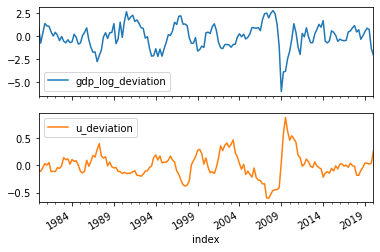

In [33]:
df.plot(subplots=True);

In [34]:
df.corr()

,gdp_log_deviation,u_deviation
gdp_log_deviation,1.000000,-0.641978
u_deviation,-0.641978,1.000000


In [35]:
df['gdp_log_deviation'].autocorr()

0.767065511115276

In [36]:
df['u_deviation'].autocorr()

0.8739499386130182

## 最小二乗法による推定

In [37]:
formula = 'gdp_log_deviation ~ u_deviation'

In [38]:
model = ols(formula, data=df)

In [39]:
result = model.fit()

In [40]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      gdp_log_deviation   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     111.5
Date:                Tue, 11 Aug 2020   Prob (F-statistic):           4.43e-20
Time:                        19:12:55   Log-Likelihood:                -231.12
No. Observations:                 161   AIC:                             466.2
Df Residuals:                     159   BIC:                             472.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0147      0.081     -0.183      